Este código estudia la distribución radio-masa para exoplanetas

-------------

Primero hago un query que me quita los valores "nan" y los valores negativos de las columnas

Luego, en base del gráfico radio-masa y de la bibliografía, defino un modelo tal que el radio sea proporcional a una potencia de la masa

 También defino la función residuo Chi2 para luego usar un optimizador/minimizador del estilo exploratorio como lo es el $\color{green}{\text{algoritmo genético}}$ y luego un ajuste fino con $\color{green}{\text{cadenas de Markov}}$ para poder obtener las incertezas en los parámetros

Por último, comparo mis resultados con un paper para ver si son compatibles

In [1]:
%matplotlib inline 
import numpy as np 
import matplotlib.pyplot as plt
import pyvo
from astropy.visualization import hist
# Estilo de gráficos
plt.style.use('dark_background')
# Servicio pyvo
service = pyvo.dal.TAPService("http://voparis-tap-planeto.obspm.fr/tap")

In /home/matt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/matt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/matt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/matt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/matt/anaconda3/lib/python3.7/site-packages/matplotlib/mpl-d

In [2]:
query = """SELECT period, mass, star_spec_type, detection_type, star_distance, radius,
radius_error_min, radius_error_max
FROM exoplanet.epn_core
WHERE mass<15 AND period>0 AND star_distance>0 AND radius_error_min>0
AND radius_error_max>0"""
res = service.search(query);

In [3]:
# Relleno listas con los valores de interés
size = np.shape(res)
Masas = [] 
Radios = [] 
Errmin = [] # Error por izquierda del radio
Errmax = [] # Error por derecha del radio

ij = 0
while ij < size[0]:
    Masas.append( res.getvalue(name='mass', index=ij) )
    Radios.append( res.getvalue(name='radius', index=ij) )
    Errmin.append( res.getvalue(name='radius_error_min', index=ij) )
    Errmax.append( res.getvalue(name='radius_error_max', index=ij) )
    ij = ij + 1
    
# Calculo los errores simétricos usando el máximo
ERR = []
ij = 0
while ij<len(Masas):
    ERR.append(max(Errmin[ij], Errmax[ij]))  
    ij = ij + 1

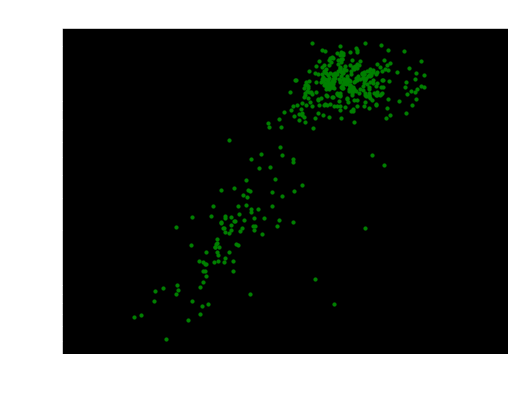

In [4]:
# Gráfico para ver la tendencia
fig, ax = plt.subplots(1, 1, figsize = (8,6))

ax.scatter(Masas, Radios, color='green', s=10);

# Tamaño de ticks
plt.rc('xtick',labelsize=15)
plt.rc('ytick',labelsize=15)
# Labels
ax.set(yscale='log', xscale='log')
ax.set_title('Escala logaritmica', fontsize=20)
ax.set_xlabel('Masa [MJup]', fontsize=20)
ax.set_ylabel('Radio [RJup]', fontsize=20)
ax.set( xscale='log', yscale='log')
ax.set_xlim(0.0001,200);

EL modelo conciste en dos funciones del estilo R = b*M^a. En su interseccion tendré que (si se intersecan en un valor de masa M=d --> b*d^a = b2*d^a2  

--> b = b2*d^(a1-a) Esta es la condición de empalme

In [5]:
# Defino el modelo.
def Modelo(Masas, a, a2, b2, d):
    """ Modelo para la función radio vs masa
    
    Parameters
    ----------
    
    Masas : list
        Lista con valores las masas [Mjup]
    a : .float
        Pendiente de la primera recta (a la izquierda)
    a2, b2 : .float, .float
        Pendiente y ordenada al origen de la segunda recta (a la derecha)
    d : .float
        Intersección de las dos rectas
        
    Returns
    -------
    Radios : list
        Lista con los valores del radio en función de la Masa
        
    """
    import numpy as np
    b = b2*(d**(a2-a)) # La condición de empalme está acá
    Radios = []
    ij = 0
    while ij<len(Masas):
        if Masas[ij]<d:
            Radios.append( b*(Masas[ij]**a) ) 
        else:
            Radios.append( b2*(Masas[ij]**a2) )
        ij = ij + 1 
    return Radios

In [6]:
# Defino el estadístico a minimizar (Chi2)
def Chi2(Params):
    """ Devuelve el valor del estadístico Chi2
    
    Parameters
    ----------
    Params : list
        Lista con los parámetros a ajustar del modelo (a, b, a2, b2 y d)
        
    Retuns
    ------
    Chi2 : .float
        Valor de Chi2
    
    """
    import numpy as np
    a, a2, b2, d = Params
    
    N = len(Masas)
    Obs = np.array(Radios)
    Calc = np.array(Modelo(Masas=Masas, a=a, a2=a2, b2=b2, d=d))
                
    Chi2 = (1/N)*np.sum( ( (Obs-Calc)/ERR )**2. )
    return Chi2

In [7]:
# Bounds para la exploración con algoritmo genético:
ra = (0, 100) # Rango de valores de "a"                      
ra2 = (0, 100) # Rango de valores de "a2"   
rb2 = (0, 100)       
rd = (0.01, 10)             

In [8]:
%%time
import scipy.optimize as optimize
bounds = (ra, ra2, rb2, rd)
resAG = optimize.differential_evolution(Chi2, bounds, strategy='best1bin', 
                                           maxiter=1000, popsize=100,tol=0.01, 
                                           mutation=(0.5, 1), recombination=0.7, 
                                           seed=None, callback=None, disp=False, 
                                           polish=True, init='latinhypercube', atol=0)

/home/matt/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:205: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


CPU times: user 13 s, sys: 108 ms, total: 13.1 s
Wall time: 12.9 s


In [9]:
# Pongo los resultados en la variable "p0"
p0 = resAG.x 
b = p0[2]*(p0[3]**(p0[1]-p0[0])) # b2*(d**(a2-a)), condición de empalme

In [10]:
# Defino la función auxiliar para usar las cadenas de Markov
def nChi2(Params):
    wi = Chi2(Params) 
    N = len(Masas)
    w2 = wi*N*(N-1) 
    return -0.5*w2

In [11]:
%%time
import emcee   
import corner  
 
ndim = len(p0)           # number of dimensions
nwalkers = 32            # number of walkers
nsteps =  4000           # total number of MCMC steps
nthreads = 4            # CPU threads that emcee should use

sampler = emcee.EnsembleSampler(nwalkers, ndim, nChi2, threads = nthreads) 
# initialize the walkers with an ndim-dimensional Gaussian ball
pos = [np.array(p0) + np.array(p0)*0.001*np.random.randn(ndim) for i in range(nwalkers)]

pos, prob, state = sampler.run_mcmc(pos, nsteps, progress = True)

100%|██████████| 4000/4000 [01:00<00:00, 66.01it/s]

CPU times: user 1min, sys: 370 ms, total: 1min
Wall time: 1min


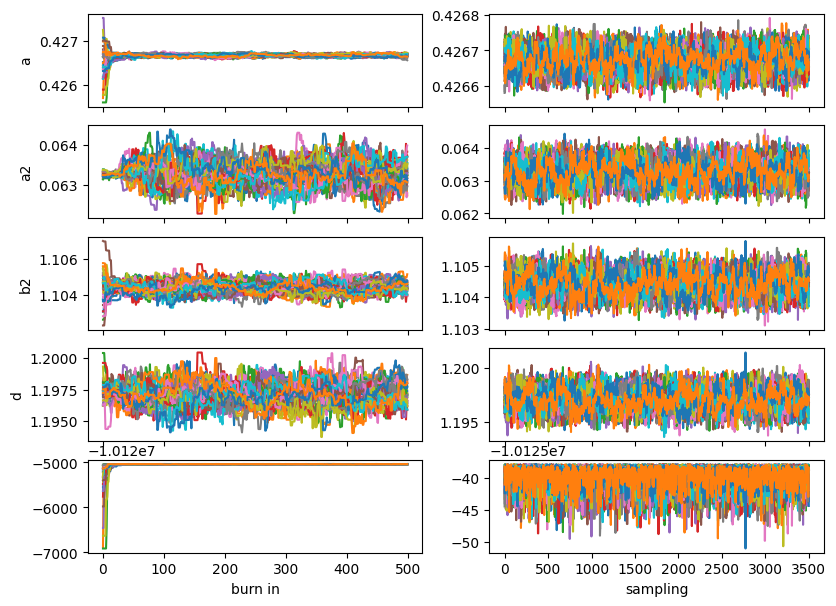

In [12]:
# Veo las cadenas
plt.style.use('default')
labels = ['a', 'a2', 'b2', 'd']
burn = 500 # Los pasos que de descartarán
fig, ax = plt.subplots(ndim + 1, 2, figsize = (9.5, 7), sharex = 'col', sharey = False)

for j in range(nwalkers):
    ax[-1,0].plot(sampler.lnprobability[j,:burn]) 
    for i in range(ndim):
        ax[i,0].plot(sampler.chain[j,:burn,i])
        ax[i,0].set_ylabel(labels[i])

for j in range(nwalkers):
    ax[-1,1].plot(sampler.lnprobability[j,burn:])
    for i in range(ndim):
        ax[i,1].plot(sampler.chain[j,burn:,i])

ax[-1,0].set_xlabel('burn in')
ax[-1,1].set_xlabel('sampling')

fig.savefig('chains.pdf')

In [13]:
# Obtengo los parámetros ajustados

i = np.unravel_index(np.argmax(sampler.lnprobability), sampler.lnprobability.shape)
par = sampler.chain[i]
par = np.median(sampler.chain[:,burn:,:].reshape((-1,ndim)),axis=0)
# s = np.std(sampler.chain[:,burn:,:].reshape((-1,ndim)),axis=0)

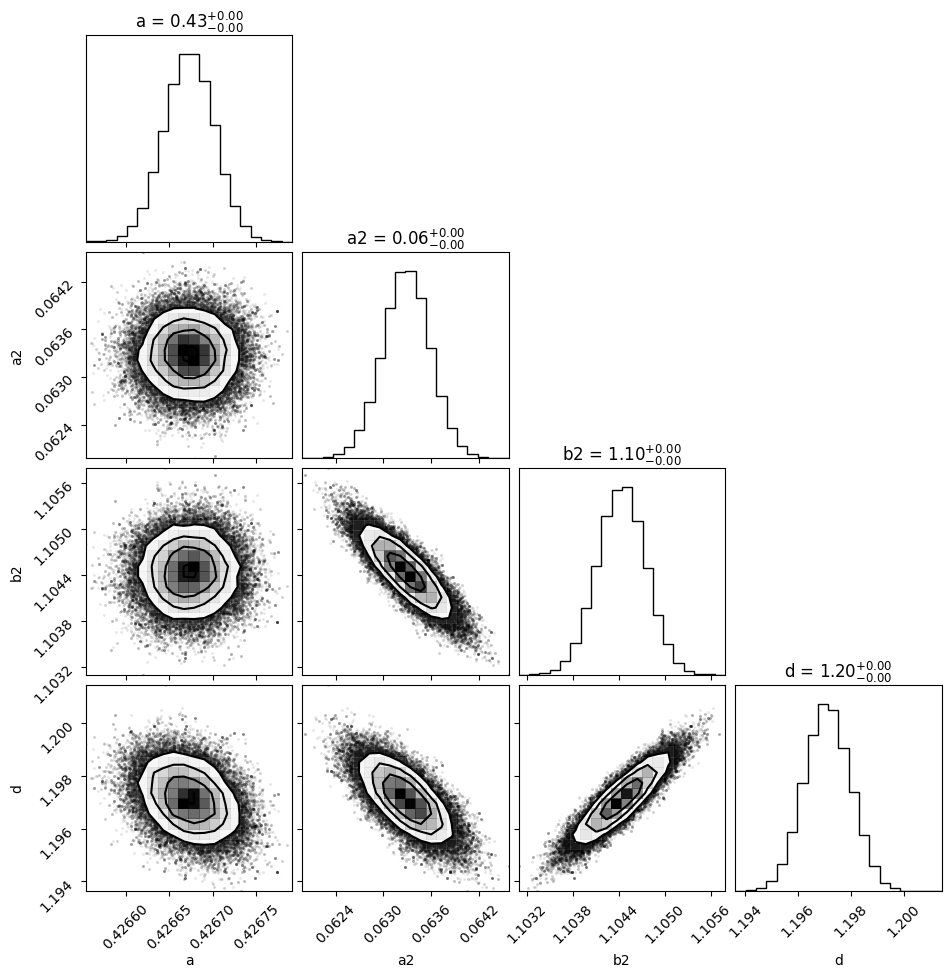

In [14]:
# Hago el corner plot
fig, ax = plt.subplots(4, 4, figsize = (10,10))
plt.style.use('default')
labels2 = ['a', 'a2', 'b2', 'd']

fig = corner.corner(sampler.chain[:,burn:,:].reshape((-1,ndim)), labels = labels2, fig = fig,
                    show_titles = True)

fig.savefig('corner.pdf')

In [15]:
plt.style.use('dark_background')

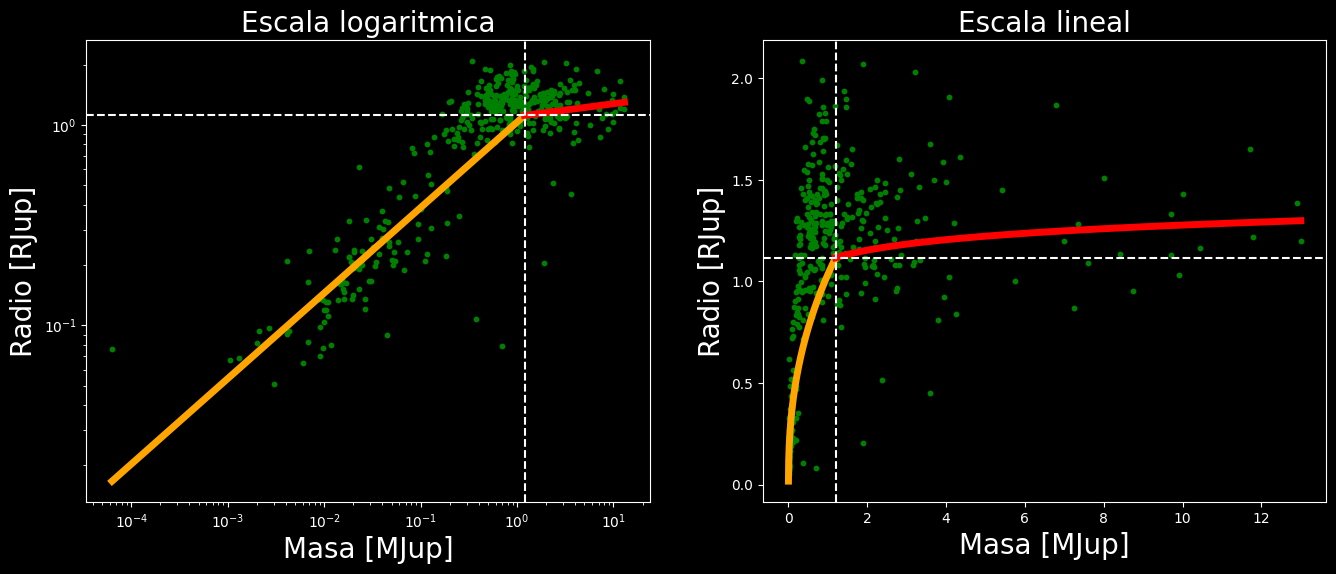

In [16]:
# Gráficos
plt.style.use('dark_background')
fig, ax = plt.subplots(1, 2, figsize = (16,6))
# Masas auxiliares para hacer las rectas:
m1 = np.linspace(min(Masas), par[3], 200)
m2 = np.linspace(par[3], max(Masas), 200)

#Escala logaritmica
ax[0].scatter(Masas, Radios, color='green', s=10);
ax[0].plot(m1, b*m1**par[0], color='orange', lw=5)
ax[0].plot(m2, par[2]*m2**par[1], color='red', lw=5)
#Escala lineal
ax[1].scatter(Masas, Radios, color='green', s=10);
ax[1].plot(m1, b*m1**par[0], color='orange', lw=5)
ax[1].plot(m2, par[2]*m2**par[1], color='red', lw=5)

# Lineas punteadas
ax[0].axvline(par[3], 0, max(Radios), ls='--', color='white')
ax[0].axhline(b*m1[-1]**par[0], 0, max(Masas), ls='--', color='white')
ax[1].axvline(par[3], 0, max(Radios), ls='--', color='white')
ax[1].axhline(b*m1[-1]**par[0], 0, max(Masas), ls='--', color='white')

ax[0].set(yscale='log', xscale='log')
ax[0].set_title('Escala logaritmica', fontsize=20)
ax[0].set_xlabel('Masa [MJup]', fontsize=20)
ax[0].set_ylabel('Radio [RJup]', fontsize=20)
ax[1].set_title('Escala lineal', fontsize=20)
ax[1].set_xlabel('Masa [MJup]', fontsize=20)
ax[1].set_ylabel('Radio [RJup]', fontsize=20);

In [17]:
# Obtención de errores, lo hago tal que el area en las colas sea del 10% (arbitrario)
# Eso implica que los cuantiles que buscaré son: el 5 y el 95
Param = np.empty(2)
ERR_DOWN = np.empty(2) # Arreglos para meter los valores
ERR_UP = np.empty(2)

ij=0
while ij<2: 
    q_05, q_50, q_95 = corner.quantile(sampler.chain[:,burn:,ij], [0.05, 0.5, 0.95]) 
    x = q_50 # Parametro ajustado
    dx_down, dx_up = q_50-q_05, q_95-q_50 # Errores
    Param[ij] = q_50
    ERR_DOWN[ij] = dx_down
    ERR_UP[ij] = dx_up
    ij = ij+1

Comparación de mis resultados con los de:
https://www.aanda.org/articles/aa/full_html/2017/08/aa29922-16/F1.html

In [18]:
# Compararé el valor de "a" y de "a2" ("a mano")
# Primero "a". Mi región de rechazo a la derecha -para a- comienza en:
print('Región de rechazo derecha para "a":', Param[0]+ERR_UP[0])
print('valor Paper a=0.55+-0.2')
# Ahora "a2"
print('Región de rechazo izquierda para "a2":', Param[1]-ERR_DOWN[1])
print('valor Paper a2=0.01+-0.2')

Región de rechazo derecha para "a": 0.4267197689594272
valor Paper a=0.55+-0.2
Región de rechazo izquierda para "a2": 0.06279039113451622
valor Paper a2=0.01+-0.2


Ambas pruebas concluyen que se rechaza la hipótesis nula (que las distribuciones son iguales). Es curioso la precisión que me dan las cadenas de Markov, no alcancé a leer el paper del cual comparo como para decir algo más. Pero sospecho que es porque el paper es de 2017 y tal vez el agregado de nuevos puntos afecta lo suficiente los datos (notar la gran dispersión para masas elevadas)